<a href="https://colab.research.google.com/github/Suvoo/Daad-Wise-prep/blob/main/JaxQuickstart_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import jax.numpy as jnp

from jax import grad, jit, vmap

from jax import lax
from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt

1. Numpy syntax is similar to JAX

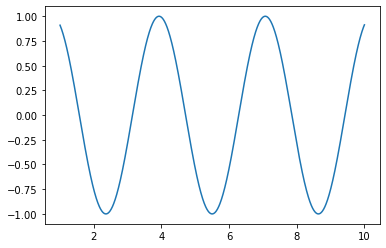

In [ ]:
# Numpy Syntax
x_np = np.linspace(1,10,1000) # start,stop,points 1000 point from 0-10 equally spaced
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np,y_np)

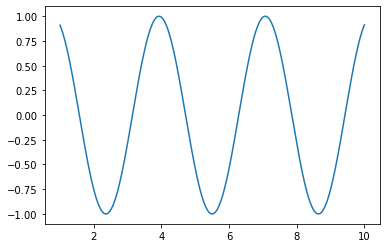

In [ ]:
# JAX Syntax
x_jnp = jnp.linspace(1,10,1000) # start,stop,points 1000 point from 0-10 equally spaced
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp,y_jnp)

2. JAX arrays are immutable(functional), but numpy arrays are mutable

In [ ]:
arr = [1,2,3,4,5,6,7,8,9,10]

# Numpy mutable
arr_np = np.array(arr)
print(arr_np)

arr_np[0] = 69
print(arr_np)

[ 1  2  3  4  5  6  7  8  9 10]
[69  2  3  4  5  6  7  8  9 10]


In [ ]:
# JAX immutable
arr_jnp = jnp.array(arr)
print(arr_jnp)

# arr_jnp[0] = 69
# print(arr_jnp)

# SOLUTION IS
brr_jnp = arr_jnp.at[0].set(69) # separate object is created, not directly
print(arr_jnp)
print(brr_jnp)

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[69  2  3  4  5  6  7  8  9 10]


3. Random Numbers are handled differently

In [ ]:
# Numpy handles in a stateful manner, but jax is stateless

#key means state
seed  = 0
key =  random.PRNGKey(seed)

x = random.normal(key, (10, ))  # you need to explicitly pass the key i.e. PRNG state
print(type(x), x)  # notice the DeviceArray type - means no need to do to.cuda like in PYTORCH

<class 'jaxlib.xla_extension.DeviceArray'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


4. JAX is AI accelerator agnostic. Same code runs everywhere! (Numpy is only for CPU Programming, but jax tpu/gpu)

In [ ]:
size = 3000

# Data is automagically pushed to the AI accelerator! (DeviceArray structure)
# No more need for ".to(device)" (PyTorch syntax)
x_jnp = random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)  # some diff in API exists!

%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()  # 1) on GPU - fast
%timeit np.dot(x_np, x_np.T)  # 2) on CPU - slow (NumPy only works with CPUs)
%timeit jnp.dot(x_np, x_np.T).block_until_ready()  # 3) on GPU with transfer overhead

x_np_device = device_put(x_np)  # push NumPy explicitly to GPU
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()  # same as 1)

# Note1: I'm using GPU as a synonym for AI accelerator. 
# In reality, especially in Colab, this can also be a TPU, etc.

# Note2: block_until_ready() -> asynchronous dispatch
# without this, work is delegated to accelerator 

The slowest run took 204.17 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 12.9 ms per loop
1 loop, best of 5: 683 ms per loop
The slowest run took 4.07 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 5: 44.4 ms per loop
100 loops, best of 5: 15 ms per loop


## JAX transform functions

1. JIT() --> compiles using XLA so it caches functions, so fast

In [ ]:
 # simple visualizer
def visualize(fn, l = -10, r = 10, n = 1000):
    x =  np.linspace(l,r,num=n)
    y = fn(x)
    plt.plot(x,y)
    plt.show()

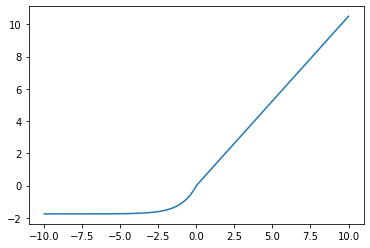

non-jit version:
The slowest run took 349.92 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 1.23 ms per loop
jit version:
The slowest run took 1976.93 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 145 µs per loop


In [ ]:
# define a sample function
# Scaled Exponential Linear Unit (SELU) activation function
def selu(x, alpha=1.67, lmbda=1.05):  # note: SELU is an activation function
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jit(selu) # using JIT on the activation func

visualize(selu) # print graph of the SELU Activation fun

# Benchmark non-jit vs jit version
data = random.normal(key, (1000000,))

print('non-jit version:')
%timeit selu(data).block_until_ready()
print('jit version:')
%timeit selu_jit(data).block_until_ready()

# Note: we'll soon see how this works (hint: jaxpr, pure functions)


In [ ]:
# just to see output
# Benchmark non-jit vs jit version
data = random.normal(key, (1000000,))
data

DeviceArray([ 1.99376   ,  0.20781846, -0.34406224, ...,  0.03467206,
              0.7103182 ,  0.1965587 ], dtype=float32)

2. GRAD() --> for differntiation (TypeError: grad requires real- or complex-valued inputs

- manual
- symbolic
- numeric
- automatic (used in jax/pytorch)


In [ ]:
# define a function (earlier sigmoid) or sum
def sum_logistic(x):
    return jnp.sum(x**2) # 2x is derivative

x = jnp.arange(3.) # same as --> jnp.array([0,1,2])
print(x)
ans = sum_logistic(x)
print(ans) # 0 + 1 + 4
grad_loss =  grad(sum_logistic)
grad_loss(x)

[0. 1. 2.]
5.0


DeviceArray([0., 2., 4.], dtype=float32)

In [ ]:
x = jnp.arange(3)

In [ ]:
ans = sum_logistic(jnp.array([0,1,2]))
ans

DeviceArray(5, dtype=int32)

In [ ]:
# First example (automatic diff)

def sum_logistic(x):  # or maybe a simpler example: sum of squares? (jnp.sum(x**2))
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x = jnp.arange(3.)
loss = sum_logistic  # rename it to give it some semantics

# By default grad calculates the derivative of a fn w.r.t. 1st parameter!
# Here we bundled inputs into a 1st param so it doesn't matter.
grad_loss = grad(loss)

print(grad_loss(x))

[0.25       0.19661194 0.10499357]


In [ ]:
# Numeric diff (to double check that autodiff works correctly)

def finite_differences(f, x):
    eps = 1e-3

    # (f(0+e, 1, 2) - f(0-e, 1, 2) )/ 2e
    return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)  # derivative definition
                                for v in jnp.eye(len(x))])

print(finite_differences(sum_logistic, x))

[0.        1.9998549 3.9999483]


In [ ]:
jnp.eye(len(x)) # this is identity matrix

DeviceArray([[1., 0., 0.],
             [0., 1., 0.],
             [0., 0., 1.]], dtype=float32)

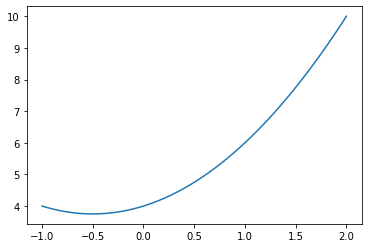

6.0 3.0 2.0 0.0


In [ ]:
# Second example(automatic diff)

x = 1.
f = lambda x: x ** 2 + x + 4
visualize(f, l=-1, r=2, n=100)

dfdx = grad(f) # 2*x + 1
d2fdx = grad(dfdx) # 2
d3fdx = grad(d2fdx) # 0

print(f(x), dfdx(x), d2fdx(x), d3fdx(x))

In [ ]:
# same as lambda func
def f1(x):
    return x**2 + x + 4
f1(x)

6.0

In [ ]:
# for 2 variables (x,y) --> by default it is differentiated by x. To change we need to set argnums = 1
x = 1.
y = 1.
f = lambda x,y: x ** 2 + x + 4 + y**2

dfdx = grad(f,argnums=(1)) # diff wrt y
print(f(x,y),dfdx(x,y))

7.0 2.0


Deriatives of vector valued func --> Jacobian

In [ ]:
 # JAX autodiff engine is very powerful ("advanced" example)

from jax import jacfwd, jacrev

f = lambda x, y: x**2 + y**2  # simple paraboloid (google it...)

# df/dx = 2x
# df/dy = 2y
# Jacobian = [df/dx, df/dy]

# d2f/dx = 2
# d2f/dy = 2
# d2f/dxdy = 0
# d2f/dydx = 0
# Hessian = [[d2f/dx, d2f/dxdy], [d2f/dydx, d2f/dy]] #matrix which is collection

def hessian(f):
    return jit(jacfwd(jacrev(f, argnums=(0, 1)), argnums =(0, 1)))

print(f'Jacobian = {jacrev(f, argnums=(0, 1))(1., 1.)}')
print(f'Full Hessian = {hessian(f)(1., 1.)}')

Jacobian = (DeviceArray(2., dtype=float32, weak_type=True), DeviceArray(2., dtype=float32, weak_type=True))
Full Hessian = ((DeviceArray(2., dtype=float32, weak_type=True), DeviceArray(0., dtype=float32, weak_type=True)), (DeviceArray(0., dtype=float32, weak_type=True), DeviceArray(2., dtype=float32, weak_type=True)))


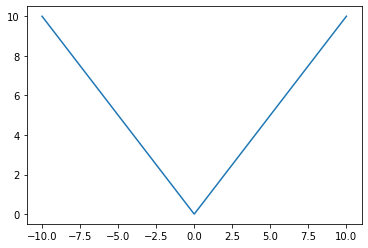

1 1
1.0 -1.0


In [ ]:
# edge case
def edge(x):
    return abs(x)
visualize(edge)

print(edge(-1),edge(1))

dfdx = grad(edge)
print(dfdx(0.),dfdx(-1.)) 
# grad is undefined at 0
# convention is +ve value

3.VMAP() --> write functions as if we are dealing with a single datapoint
- removes  for loop, does all at once



In [ ]:
W = random.normal(key, (150, 100))  # e.g. weights of a linear NN layer
batched_x = random.normal(key, (10, 100))  # e.g. a batch of 10 flattened images

def apply_matrix(x):
    return jnp.dot(W, x)  # (150, 100) * (100, 1) -> (150, 1) # only for a single image, not a batch

In [ ]:
# iterate through all
def naively_batched_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready

Naively batched
The slowest run took 86.90 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 3.12 ms per loop


In [ ]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T)  # (10, 100) * (100, 150) -> (10, 150)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
The slowest run took 623.84 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 93.9 µs per loop


In [ ]:
@jit  # Note: we can arbitrarily compose JAX transforms! Here jit + vmap.
def vmap_batched_apply_matrix(batched_x):
    return vmap(apply_matrix)(batched_x)

# Task: modify apply_matrix to have 2 inputs and use in_axes arg

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
The slowest run took 299.84 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 43.4 µs per loop
